In [20]:
# import sys
# print (sys.version)

# Import libraries for Finance (Yahoo Finance) and Technical Analysis
import yfinance as yf
import talib

# Import libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Hide warnings except for once
import warnings
#warnings.filterwarnings(action='once')

#Import internal functions to load data, etc
#import initialize

#Setting up constants
QUICK_EMA_PERIOD = 7
SLOW_EMA_PERIOD = 14

In [21]:
def init(fromCSV = False, numberOfStocks = 10, daysSince=14, typeDate='Close'):

    if (fromCSV == True):
        print ("Returning stored data.")
        return ((pd.read_csv('rawdata.csv')).set_index('Date'))

    print(f"Requested days: {daysSince}.\nRequested stocks: {numberOfStocks}.\nData type: {typeDate}.")

    tickers_df = pd.read_csv('sp500_tickers.csv').head(numberOfStocks)
    tickers_df.set_index('Ticker', inplace=True)
    tickers_df.sort_values(by='Ticker', inplace=True)

    tickers_string = ' '.join(tickers_df.index.values)
    ts_today = pd.to_datetime('today')
    ts_origin = ts_today - pd.Timedelta(days=daysSince)


    return (yf.download(tickers_string, start=ts_origin, end=ts_today)[typeDate])

    
#(rawdata) = init(fromCSV=True, numberOfStocks=5000, daysSince=30)
#rawdata.to_csv('./rawdata.csv')
#companies = rawdata.columns.values


def real2double(real_data):
    return(np.array(real_data,dtype='f8'))
    

In [22]:
def get_EMA_df(qema_period, sema_period, rawdata):
    '''Builds a multiindex dataframe composed of two sub-dfs: quick and slow EMA'''
    df_dict = dict((label, pd.DataFrame()) for label in ['Quick', 'Slow', 'Ratio'])

    for x in rawdata.columns:
        df_dict['Quick'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)
        df_dict['Slow'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=sema_period)
        df_dict['Ratio'][x] = 100*(df_dict['Quick'][x] - df_dict['Slow'][x])/df_dict['Quick'][x]

    return(pd.concat([df_dict['Quick'], df_dict['Slow'], df_dict['Ratio']], axis=1, keys=['Quick', 'Slow', 'Ratio']))

#EMA_df = get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD)

In [23]:
def get_intersection_point(EMA_df, rawdata):
    '''Returns a df containing:
    Index from where the qEMA started leading the sEMA.
    Value at that time
    Value now
    Average growth since turning point
    '''
    item_positive_bool = (EMA_df['Quick'] - EMA_df['Slow'])>0
    idx_intersection_dict = dict()
    value_intersection_dict = dict()
    value_now_dict = dict()
    growth_dict = dict()

    for company in item_positive_bool.columns:

        #Get the index when qEMA started bullysh trend
        company_positive_bool =(list(item_positive_bool[company]))
        company_positive_bool.reverse()
        turning_change_index = company_positive_bool.index(False)
        idx_intersection_dict[company] = turning_change_index

        #Get both values by the intersection and current, and associated growth
        value_intersection_dict[company] = round(rawdata[company].iloc[-(turning_change_index+1)],2)
        value_now_dict[company] = round(rawdata[company].iloc[-1],2)
        growth_dict[company] = round(100*(value_now_dict[company] - value_intersection_dict[company])/value_intersection_dict[company],2)

    intersection_points_df = pd.DataFrame([idx_intersection_dict, value_intersection_dict, value_now_dict, growth_dict],
        index = ["Turning point", "Turning value", "Value now", "Percent Growth"]).transpose()#.sort_values(by="Percent Growth", ascending=False)
    
    
    return (intersection_points_df)

#keyStats = get_intersection_point(EMA_df, rawdata)

In [24]:
def ratioWrapper(EMA_df, companies, keyStats):
    '''Return two more columns 
    - Average ratio of qEMA / sEMA since qEMA started leading (bullysh trend)
    - Minimum value of that ratio since that moment PLUS two periods (to allow the qEMA to gain momentum)

    The goal is to put first those companies with a stronger qEMA leadership.
    '''
    avgRatio_list = []
    minAbs_list = []

    for company in companies:
        
        getFrom = int(keyStats['Turning point'].loc[company])
        avgRatio = round(EMA_df['Ratio'][company][-getFrom:].mean(),2) * (getFrom > 0 ) 
        avgRatio_list.append(avgRatio)

        MinAbsRatio = round(EMA_df['Ratio'][company][-getFrom+2:].min(),2) * (getFrom > 0 ) 
        minAbs_list.append(MinAbsRatio)

    return (avgRatio_list, minAbs_list)

#(keyStats['avgRatio'], keyStats['MinAbsRatio']) = ratioWrapper(EMA_df, companies, keyStats)


In [25]:
def filter_companies(keyStats, aboveAvgRatio=False, aboveMinAbs=False, minPositivePeriod = False):
    keyStats.sort_values(by='avgRatio', ascending=False, inplace=True)
    if(aboveAvgRatio):
        keyStats = keyStats[keyStats['avgRatio'] >= aboveAvgRatio]
    if(aboveMinAbs):
        keyStats = keyStats[keyStats['MinAbsRatio'] >= aboveMinAbs]
    if(minPositivePeriod):
        keyStats = keyStats[keyStats['Turning point'] >= minPositivePeriod]
    result = pd.DataFrame({'Symbol': keyStats.index.values})
    return (result)

#filteredCompanies = filter_companies(keyStats, aboveAvgRatio=1, aboveMinAbs=1, minPositivePeriod=4)
#filteredCompanies.to_csv("./archive/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d'))

In [26]:
#(filteredCompanies['Symbol'].values)




In [27]:
#This function needs review because we changed the definition of filterecompanies to a dataframe for CSV purposes.

def reset_filtered_companies():
    global filteredCompanies
    filteredCompanies = companies


In [28]:
def plot_all(rawdata, EMA_df, filteredCompanies, limit=10):
    print (f"Displaying {limit} first companies")
    x_axis = rawdata.index

    for x in (filteredCompanies[0:limit]['Symbol']):
        #print(f"Company {x}, with {keyStats.loc[x][0]} periods")
        plt.plot(x_axis, EMA_df['Quick'][x], 'r')
        plt.plot(x_axis, EMA_df['Slow'][x], 'b')
        plt.plot(x_axis, rawdata[x], 'g')
        plt.show()

In [29]:
#plot_all(filteredCompanies, limit=10)

In [30]:
""" x_axis = rawdata.index

selCompanies = filteredCompanies[0:10]['Symbol']
fig, axs = plt.subplots(nrows=10, sharex=True)

for (ax, company) in zip(axs, selCompanies):
    ax.set_title(company)
    ax.plot(x_axis, EMA_df['Quick'][company], color='r')
    ax.plot(x_axis, EMA_df['Slow'][company], color='b')
    ax.plot(x_axis, rawdata[company], color='g')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) """
    
    #ax.xaxis.set_minor_locator(mdates.MonthLocator())
    #ax.grid(True)
    #ax.set_ylabel(r'Price [\$]')

" x_axis = rawdata.index\n\nselCompanies = filteredCompanies[0:10]['Symbol']\nfig, axs = plt.subplots(nrows=10, sharex=True)\n\nfor (ax, company) in zip(axs, selCompanies):\n    ax.set_title(company)\n    ax.plot(x_axis, EMA_df['Quick'][company], color='r')\n    ax.plot(x_axis, EMA_df['Slow'][company], color='b')\n    ax.plot(x_axis, rawdata[company], color='g')\n    ax.tick_params(axis='x', labelrotation = 45)\n    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) "

In [31]:
def plot_one(x):
        plt.plot(x_axis, EMA_df['Quick'][x], 'r')
        plt.plot(x_axis, EMA_df['Slow'][x], 'b')
        plt.plot(x_axis, rawdata[x], 'g')
        plt.show()

In [32]:
def get_stocks_growing_now(rawdata, keyStats, recent_success_period):
    contribution_list = []
    for x in keyStats.index:
        #Calculate the Y-axis range (max-min of stock in both time frames) and its ratio
        range_local = rawdata[x][-recent_success_period:].values.max() - rawdata[x][-recent_success_period:].values.min()
        range_global = rawdata[x].values.max() - rawdata[x].values.min()
        contribution_recent = range_local/range_global
        
        #Get the X-Axis range (selected time frame w.r.t. total time analysed)
        proportion_recent = recent_success_period/rawdata.shape[0]

        #Get the final ratio and append to list.
        #Ratio 1 means that for 25% of timeframe, 25% of stock range is achieved.
        contribution_ratio = round(contribution_recent/proportion_recent,2)
        contribution_list.append(contribution_ratio)

        #print(f"For {x} in the past {recent_success_period} periods the range was {range_local} over {range_global}, hence contribution ratio is {contribution_ratio}")
        #print(f"Details: contribution_recent = {contribution_recent}, proportion_recent = {proportion_recent}")
    return (contribution_list)

#keyStats['ratioContr'] = get_stocks_growing_now(5)




In [33]:
""" toshow = filteredCompanies['Symbol'][0:10]
keyStats.loc[toshow, 'ratioContr'] """

" toshow = filteredCompanies['Symbol'][0:10]\nkeyStats.loc[toshow, 'ratioContr'] "

In [34]:
""" #Visualize the stock for assessment
study = 'PHM'
plot_one(study)

#Model 2: calculate the contribution of the last X days to total growth in the analysis window. Accept if surpassed
recent_success_period = 5

range_local = rawdata[study][-recent_success_period:].values.max() - rawdata[study][-recent_success_period:].values.min()
range_global = rawdata[study].values.max() - rawdata[study].values.min()
contribution_recent = range_local/range_global
proportion_recent = recent_success_period/rawdata.shape[0] """


" #Visualize the stock for assessment\nstudy = 'PHM'\nplot_one(study)\n\n#Model 2: calculate the contribution of the last X days to total growth in the analysis window. Accept if surpassed\nrecent_success_period = 5\n\nrange_local = rawdata[study][-recent_success_period:].values.max() - rawdata[study][-recent_success_period:].values.min()\nrange_global = rawdata[study].values.max() - rawdata[study].values.min()\ncontribution_recent = range_local/range_global\nproportion_recent = recent_success_period/rawdata.shape[0] "

In [35]:

#Model 1: calculate contribution of each day, if a maximum is reached then discard.
""" max_raw = rawdata[study].values.max()
min_raw = rawdata[study].values.min()
range = max_raw - min_raw

contribution = (rawdata[study] - min_raw)/range


glory_threshold = 0.8
glory_bool = contribution > glory_threshold
glory_verif = list(glory_bool).index(True)
glory_verif < 0.7*len(glory_bool) """

' max_raw = rawdata[study].values.max()\nmin_raw = rawdata[study].values.min()\nrange = max_raw - min_raw\n\ncontribution = (rawdata[study] - min_raw)/range\n\n\nglory_threshold = 0.8\nglory_bool = contribution > glory_threshold\nglory_verif = list(glory_bool).index(True)\nglory_verif < 0.7*len(glory_bool) '

In [36]:
#The idea of plotting stocks to assess the market status is good, but considering these magnitudes as separate can yield misleading results.
#For example there is a stock with ratioContr = 4, but if you look at the stock it is zigzagging massively. 
#We would have avoided it if we had discarded it due to non verification of qema > sema.

#In other words, these magnitudes must be applied at the same time. The only really useful result is the final result of eligible stocks.

#The other thing we can do is to apply a pre-filter and then analyze the results. This will tell us how the population is moving.
#e.g set ratiocontr > 0.3 && avgRatio > 1% and then plot the results. Or, even plot everything with different colors (non-acceptable points in red)
""" fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.scatter(keyStats['ratioContr'], keyStats['avgRatio'], keyStats['MinAbsRatio'], linewidth=2.0)


plt.show() """

' fig, ax = plt.subplots(subplot_kw={"projection": "3d"})\n\nax.scatter(keyStats[\'ratioContr\'], keyStats[\'avgRatio\'], keyStats[\'MinAbsRatio\'], linewidth=2.0)\n\n\nplt.show() '

In [37]:
#plot_one('AIG')

Returning stored data.


/var/folders/5_/77bq8h093_sd9djb8xy8w02h0000gn/T/ipykernel_2156/427354246.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_dict['Quick'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=qema_period)
/var/folders/5_/77bq8h093_sd9djb8xy8w02h0000gn/T/ipykernel_2156/427354246.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_dict['Slow'][x] = talib.EMA(real2double(rawdata[x].values), timeperiod=sema_period)
/var/folders/5_/77bq8h093_sd9djb8xy8w02h0000gn/T/ipykernel_2156/427354246.py:8: PerformanceWarning: DataFra

Displaying 10 first companies


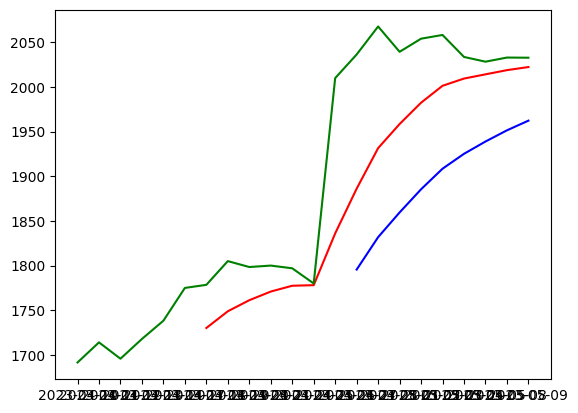

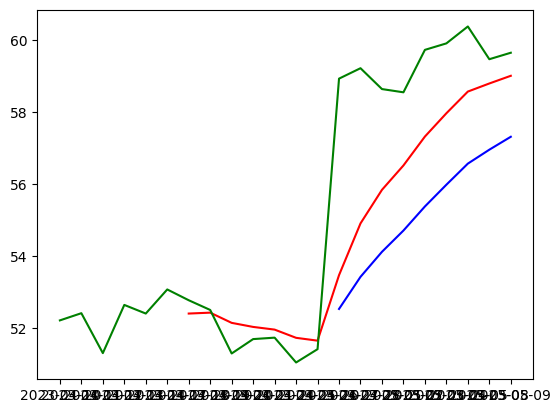

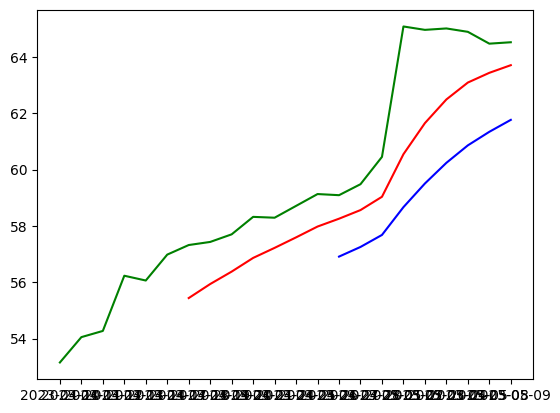

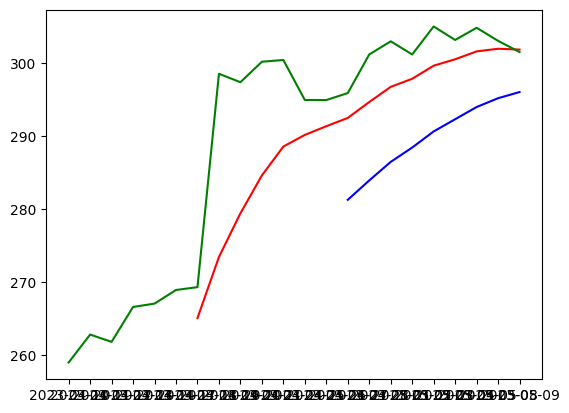

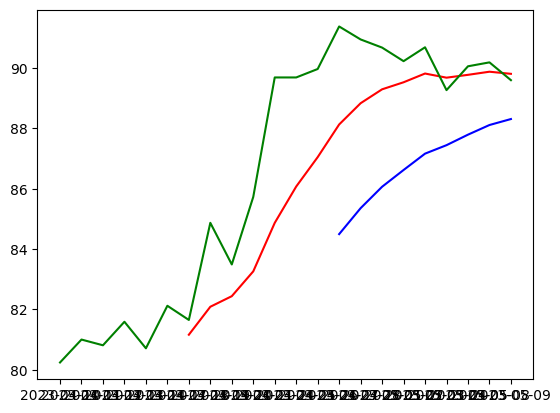

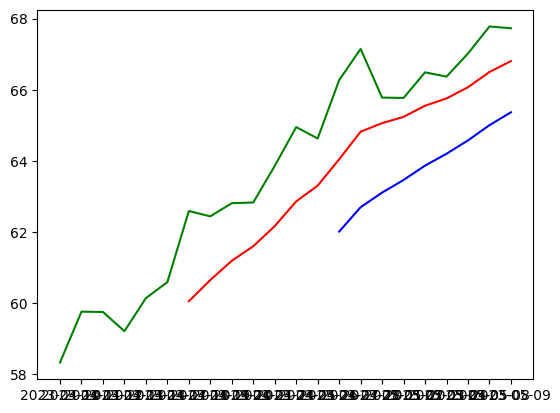

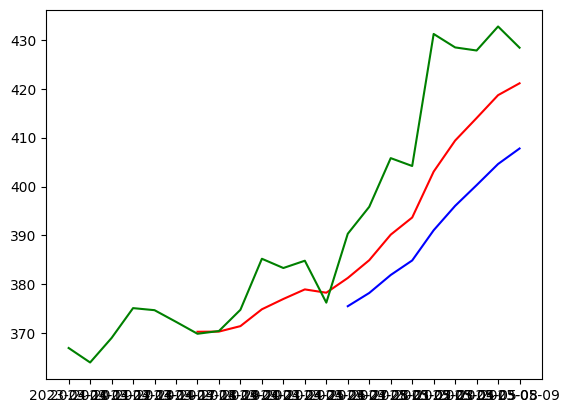

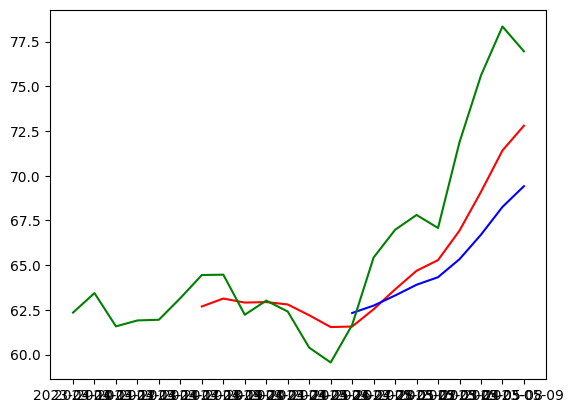

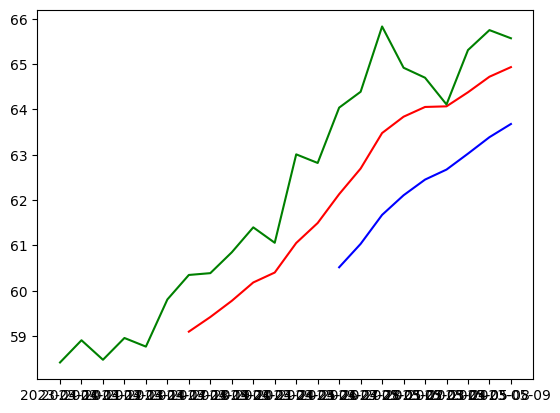

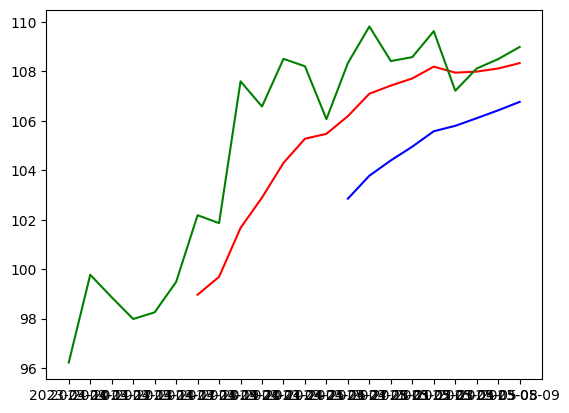

In [38]:
# import sys
# print (sys.version)

# Import libraries for Finance (Yahoo Finance) and Technical Analysis
import yfinance as yf
import talib

# Import libraries for data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Hide warnings except for once
import warnings
#warnings.filterwarnings(action='once')

#Import internal functions to load data, etc
#import initialize

#Setting up constants
QUICK_EMA_PERIOD = 7
SLOW_EMA_PERIOD = 14

def run_application():
    #(fromCSV, numberOfStocks, timeframes:{daysSince, qema_period, sema_period}, filters: {aboveAvgRatio, aboveMinAbs, aboveRatioContr})
    rawdata = init(fromCSV=True, numberOfStocks=5000, daysSince=30)
    rawdata.to_csv('./rawdata.csv')
    companies = rawdata.columns.values

    EMA_df = get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, rawdata)
    keyStats = get_intersection_point(EMA_df, rawdata)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = ratioWrapper(EMA_df, companies, keyStats)
    keyStats['ratioContr'] = get_stocks_growing_now(rawdata, keyStats, 5)
    filteredCompanies = filter_companies(keyStats, aboveAvgRatio=1, aboveMinAbs=1, minPositivePeriod=4)
    filteredCompanies.to_csv("./archive/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 

    plot_all(rawdata, EMA_df, filteredCompanies, limit=10)

run_application()